# Taller ML no Spervisado: Mushroom Dataset (Clustering and PCA)

### Estructura de mi cuaderno:

1. Setup y carga de daatos (librerías y pd.read_csv)
2. Exploración inicial (head, describe, info y cuenta de nulos inicial)
3. Análisis de variables con Nulos (búsqueda profunda de falsos nulos)
4. Imputación avanzada de Nulos (KNN)
5. Limpieza y codificación
    - PCA (Reducción de Dimensionalidad)
    - Modelo Supervisado (Random Forest)
    - Clustering (Kmeans)


## 1. Setup y carga de daatos (librerías y pd.read_csv)

###  Librerías
- Mushroom Dataset

- Enlace directo al dataset:

[Mushroom Dataset](https://www.kaggle.com/uciml/mushroom-classification)

Observaciones del profe:
- Todas las variables de este dataset son categóricas
- Por lo tanto, exploraciones con scatterplot no nos serán útiles como en otros casos

- ¿Qué significa cada columna?
- ¿Objetivo de este notebook?  La variable a predecir ``poisonous``, que es binaria.

- MIRAR LA METADA DE QUE SIGNIFICA CADA COLUMNA


In [2]:
#%%capture
# Hay que poner esta es una magi cell, en la primera linea de la celda, sin NADA antes, ni siquiera un comentario. Si pongo algo antes, Jupyter no lo reconoce como magic cell y falla. Sirve para ocultar la salida de esta celda, que es solo la instalación de librerías. No queremos que el output del notebook se llene de mensajes de instalación cada vez que lo ejecutamos.
# Y como no tengo un pip install debajo al que silenciar, no necesito esta cell magic.

#%pip install missingno
#como estoy trabajando en local, con mi propio Python global, no necesito pip install dentro del notebook. Mis librerías ya están instaladas y persisten. Si estuviera trabajando en Google colab, que es un entorno en la nube donde cada vez abro una sesión, el entorno se reinicia desde cero - todas las librerías que no son estandar desaparecen. Por eso lo habitual es poner un pip install al principio.

In [3]:
# Carga de las librerías necesarias para la limpieza

# - Para manipulación de datos -
import pandas as pd # Librería que utilizamos para trabajar con tablas de datos en Python (como excel pero en código). La usamos aqui para cargar el CSV, explorarlo, filtras columnas, contar nulos, crear nuevos DataFrame.
import numpy as np #Librería de matemáticas y arrays numéricos. La usamos aquí para crear rangos de números (np.arrange), para trabajar con operaciones matemáticas durante PCA y KMeans, y para convertir DataFrames a arrays numéricos (np.array).

# - Para visualizacion -
import seaborn as sns #Librería de visualización estadística. Hace gráficas bonitas con muy poco código. La usamos para los countplots del EDA, el catplot de clusters vs clase real, y el lineplot del método del codo. Alias sns. Viene de "Samuel Norman Seaborn", un personaje de The West Wing. Sí, en serio profe.
import matplotlib.pyplot as plt #Es la librería de base de gráficas en Python. La usamos para mostrar las gráficas de Seaborn, La usamos aquí para el scatterplot del PCA, controlar tamaños, títulos, y guardar gráficas. Seaborn hace las gráficas bonitas, matplotlib las personaliza y las muestra.

# - Para el modelado: clustering y reduccion de dimensionalidad -
from sklearn.cluster import KMeans #Es el algoritmo de clustering KMeans de scikit-learn. Aqui lo usamos para agrupar los mushrooms en clusters in usar las etiquetas. El modelo buscará grupos naturales en los datos solo por similitud matemática. Punto clave a tener en cuenta: 'from sklearn.cluster' indica que viene del módulo de aprendizaje no supervisado de scikit-learn, y 'import KMeans' es el algoritmo específico que vamos a usar.
from sklearn.decomposition import PCA # Es la clase de PCA (Análisis de Componentes Principales) de Scikit-learn. Aqui la usamos para reducir dimensionalidad de los datos, es decir, para transformar las 22 columnas originales en solo 2 componentes principales que capturan la mayor parte de la variabilidad. Aqui la usamos para 2 usos distintos: 1. Visualización: comprimir 22 + variables en 2 dimensiones para poder pintarlas. y 2. Preprocesamiento: reducir dimensiones antes de entrenar modelos, para ver si mejoran o empeoran. Es útil para eliminar ruido y redundancia, y para entender mejor la estructura de los datos. PCA encuentra nuevas variables (componentes) que son combinaciones lineales de las originales, ordenadas por la cantidad de varianza que explican. La primera componente explica la mayor parte de la varianza, la segunda explica la siguiente mayor parte, y así sucesivamente. Al quedarnos solo con las primeras componentes, perdemos algo de información pero ganamos simplicidad y a menudo mejor rendimiento en modelos.

# - Para el modelado: clasificacion supervisada -
from sklearn.ensemble import RandomForestClassifier # Es un clasificador supervisado que contruye muchos árboles de decisión y combina sus votos. Aqui lo usamos para comparar su desempeño con KMeans, pero esta vez usando las etiquetas reales de (comestible/venenoso) pra entrenar el modelo, y compararemos su precisión con lo que encuentra KMeans sin etiquetas. 'ensemble' significa que combina múltiples modelos - un "bosque" de árboles. Es un modelo poderoso que maneja bien datos con muchas características y es robusto al ruido. Al ser un modelo supervisado, necesita las etiquetas de clase para aprender, a diferencia de KMeans que es no supervisado.


# Para el preprocesamiento de datos antes de PCA y KMeans -
from sklearn.preprocessing import StandardScaler # Es una herramienta que escala los datos para que todas las variables tengan media 0 y desviación estandar 1. Es OBLIGATORIO antes de PCA porque PCA mide varianza, es decir, es sensible a la escala de variables. O sea, si una variable va de 0 a 1000 y otra de 0 a 1, PCA creerá que la primera es más importante solo por su escala. El escalado pone todas las variables en igualdad de condiciones. Regla de oro a recordar: 'StandardScaler' siempre antes de PCA y antes de KMeans.
from sklearn.model_selection import train_test_split # Es una función que divide los datos en dos partes: entrenamiento y prueba. La usamos aqui para que el modelo aprenda con el 67% de los datos (train) y luego evaluamos su desenpeño con el 33% restante que nunca ha visto (test). Esto mide si el modelo generaliza bien o solo memorizó. (Me preguntaba porqué en este notebook se han configurado el 67/33 en lugar del típico 80/20 o 70/30, ya que es el punto donde suele haber suficientes datos para que el modelo aprenda bbien y suficiente para evaluarlo con fiabilidad. Se ve que utizaron este split porque el dataset tiene más de 8000 filas, así que incluso con 33% de test hay más de 2600 ejemplos paa evaluar, lo cual es robusto. Con datasets grandes podemos permitirnos dar mas datos al test sin perjudicar el entrenamiento. Regla general para decidir en el futuro: si mi dataset es pequeño (menos de 1000 filas), deberia usar 80/20 o incluso 90/10 para que el modelo tenga suficiente con qué aprender. Si mi dataset es más grande, puedo ser más generosa con el test())

# - Configuración de métricas de evaluación de modelos -
from sklearn.metrics import accuracy_score, classification_report # Son funciones para evaluar el desempeño de modelos de clasificación. Aquí las usamos para medir la precisión del Random Forest comparando sus predicciones con las etiquetas reales. Aqui el 'accuracy_score' nos da la proporción de predicciones correctas, mientras que el 'classification_report' nos da un desglose más detallado de precisión, luego, recall y F1-score para cada clase. Estas métricas nos ayudarán a entender no solo cuántas predicciones fueron correctas, sino también cómo se comporta el modelo con cada clase (comestible vs venenoso). Es decir, accuracy_score nos da el número rápido ("97% de acierto"). El classification_report nos dice si ese 97% real o si el modelo está fallando en una clase concreta (venenoso) y acertando todo en la otra (comestible), lo cual sería un problema. Por eso es importante mirar ambas métricas para tener una imagen completa del desempeño del modelo.


### Además, añadiremos las constantes de configuración global:


 Añaidmos la semilla global RANDOM_STATE=42 para no tener que escribirla nuevamente en 5 sitios distintos. La definimos una vez y ya está. Si algún día decido cambiar la semilla, solo cambio este numero y afecta a todos los modelos.
 O sea, qué hace la semilla global esa? ella es el punto de partida de todos los algoritmos que tienen componente aleatorio (KMeans, RandomForest, train_test_split).

 ¿Porqué? pues porque sin ella, cada vez que ejecute el notebook obetendré resultados ligeramente diferentes.

 Con ella, los resultados son siempre iguales > reproducibilidad. Y por qué 42? Es una convención humorística de la comunidad Data Science (referencia a "The Hitchhiker's Guide to the Galaxy"). Cualquier número funcionaría.

 Bueno, y por qué en capslock? porque las constantes globales siempre van en mayúscula en python (que no me acordaba). Esto le dice a cualquier lector "esto no debe cambiar dentro del código".

In [4]:

# Constante de Configuración de gráficas - La usamos para establecer el estilo visual de todas las gráficas del notebook de una vez. "whitegrid" = fondo blanco con cuadrícula. (10,6) = tamaño de gráficas en pulgadas.
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Semilla global — la usaremos en todos los modelos para reproducibilidad
RANDOM_STATE = 42

print("✅ Librerías listas")


✅ Librerías listas


###  Leer conjunto de datos y primer vistazo

¿Qué haré?

**Leer el CSV desde la carpeta data/raw y mostrar las primeras 5 filas** para confirmar que se cargó correctamente.

¿Por qué así?

Usamos *rutas relativas* (../data/raw/mushrooms.csv) en lugar de rutas absolutaas (C:/Users/USUARIO/...) porque si en el futuro, llego a compartir el proyecto con alguien o lo subo a GitHub, la ruta absoluta rompería el ordenador de otra persona. La relativa funciona en cualquier máquina.

¿Qué alternativas tenemos?
 * pd.read_csv() con ruta absoluta > funciona pero no es portable
 * ucimlrepo > descarga el CSV automaticamente pero requiere internet
 * *Lo que elegí* > CSV local con ruta relariva > portable y profesional


In [10]:
# Cargar el dataset desde la carpeta de datos crudos (ruta relativa al notebook)
df = pd.read_csv("../data/raw/mushrooms.csv")

print("✅ Dataset cargado")

#Primer vistazo: shape nos dice (filas, columnas)
print(f"Dimensiones del dataset: {df.shape[0]} filas y {df.shape[1]} columnas")
print(f"Columnas: {df.columns.tolist()}")



✅ Dataset cargado
Dimensiones del dataset: 8124 filas y 23 columnas
Columnas: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


## 2. Exploración inicial (head, describe, info y cuenta de nulos inicial)

¿Qué vamos hacer? Haremos dos inspecciones estándar que **siempre** se hacen al cargar un dataset:

1. Descripción del conjunto de datos, estándard. - .head(), - .describe() - estadísticas básicas de cada columna
2. .info() o dtypes - tipo de dato de cada columna

¿Porqué?
en un dataset numérico, *.describe()* te da medias, máximos, mínimos. Aquí todo es *object* (texto), así que lo que nos interesa confirmar es:

* ¿Todas las columnas son tipo *object*? (si alguna fuera int o float sería raro)
* ¿Cuántas filas tiene cada columna? (para detectar nulos indirectamente)



* 1. Descripción del conjunto de datos, estándard.

In [ ]:
# Las 5 primeras filas
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [ ]:
# Estadísticas descriptivas para variables categóricas


# 'include="all"' es necesario porque si no, describe() ignora columnas de texto
df.describe(include='all')


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


*  2. Información sobre el tipo de datos de cada feature.

Lo más importante a observar aqui es:

    -¿Todas las columnas son *object*?
    -¿ Hay alguna columna con menos de 8124 valores no-nulos? (señal de nulos)

In [ ]:
# Tipos de datos y memoria usada — confirma que todo es categórico (object)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

## 3.  Análisis de Variables con Nulos (Contar el número de nulos "reales")

Igual que otras veces, una linea, contar los nulos por variable.

In [ ]:

# Contar NaN reales (spoiler: no habrá ninguno en este dataset)
print("=== Nulos tipo NaN ===")
print(df.isnull().sum())

# Pero en este dataset los nulos están disfrazados como '?'
# Vamos a buscarlos contando cuántas veces aparece '?' en cada columna
print("\n=== Valores '?' por columna (nulos disfrazados) ===")
print((df == '?').sum()[( df == '?').sum() > 0])

=== Nulos tipo NaN ===
class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

=== Valores '?' por columna (nulos disfrazados) ===
stalk-root    2480
dtype: int64


### Nota para mi futura yo (BÚSQUEDA DE NULOS Y FALSOS NULOS)
Vale, Solo he sabido que habían falsos nulos disfrazados de ? porque este dataset es conocido por la IA (y porque lo han mencionado en clase).

Peeeeero, si no supiera que están ahi (es decir, si estuviera trabajando un dia normal, qué debo hacer para encontrarlos?).
Quiero saber qué debo hacer para buscar falsos nulos, porque seguramente la mayoria de los datasets estará lleno de ellos.

Me dice Tito GePeTo que deberia seguir una estratégia profesional para detectar falsos nulos. Y esa estrategica es:

1. Revisar valores únicos por columna (clave)
2. Contar frecuencia de todos los valores
3. Buscar strings sospechosos automáticamente
4. Detectar categorías muy poco frecuentes




### 1. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Revisar valores únicos por columna (clave)

In [ ]:
for col in df.columns:
    print(col)
    print(df[col].unique())
    print("-----")

class
['p' 'e']
-----
cap-shape
['x' 'b' 's' 'f' 'k' 'c']
-----
cap-surface
['s' 'y' 'f' 'g']
-----
cap-color
['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
-----
bruises
['t' 'f']
-----
odor
['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
-----
gill-attachment
['f' 'a']
-----
gill-spacing
['c' 'w']
-----
gill-size
['n' 'b']
-----
gill-color
['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
-----
stalk-shape
['e' 't']
-----
stalk-root
['e' 'c' 'b' 'r' '?']
-----
stalk-surface-above-ring
['s' 'f' 'k' 'y']
-----
stalk-surface-below-ring
['s' 'f' 'y' 'k']
-----
stalk-color-above-ring
['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
-----
stalk-color-below-ring
['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
-----
veil-type
['p']
-----
veil-color
['w' 'n' 'o' 'y']
-----
ring-number
['o' 't' 'n']
-----
ring-type
['p' 'e' 'l' 'f' 'n']
-----
spore-print-color
['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
-----
population
['s' 'n' 'a' 'v' 'y' 'c']
-----
habitat
['u' 'g' 'm' 'd' 'p' 'w' 'l']
-----


*Esto revela cualquier símbolo raro:*

*'?'* | *'NA'* | *'N/A'* | *'none'* | *'' (string vacío)* | *'unknown'*

*Esto es el método más directo.*

    *- Aqui vemos todos los valores, pero en un princpio no vemos nada raro*

### 2. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Contar frecuencia de todos los valores

In [ ]:
for col in df.columns:
    print(col)
    print(df[col].value_counts(dropna=False))
    print("-----")

class
class
e    4208
p    3916
Name: count, dtype: int64
-----
cap-shape
cap-shape
x    3656
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64
-----
cap-surface
cap-surface
y    3244
s    2556
f    2320
g       4
Name: count, dtype: int64
-----
cap-color
cap-color
n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: count, dtype: int64
-----
bruises
bruises
f    4748
t    3376
Name: count, dtype: int64
-----
odor
odor
n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: count, dtype: int64
-----
gill-attachment
gill-attachment
f    7914
a     210
Name: count, dtype: int64
-----
gill-spacing
gill-spacing
c    6812
w    1312
Name: count, dtype: int64
-----
gill-size
gill-size
b    5612
n    2512
Name: count, dtype: int64
-----
gill-color
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     408
e      96
y      86
o      64
r      24


### 3. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Buscar strings sospechosos automáticamente

In [ ]:
import re

for col in df.select_dtypes(include='object'):
    suspicious = df[col].str.contains(r'^\s*$|unknown|na|n/a|\?', case=False, na=False)
    if suspicious.any():
        print(f"Posible falso nulo en: {col}")

Posible falso nulo en: stalk-root


*Esto detecta:*

*?*  |  *espacios vacíos*  |  *unknown*  |  *na*  y también el  *n/a*

    - De acuerdo, aqui me dice el nombre de la columna en la que podrÍa haber un falso nulo, pero sigo sin ver el valor '?'

### 4. (BÚSQUEDA DE NULOS Y FALSOS NULOS) Detectar categorías muy poco frecuentes
 A veces los falsos nulos aparecen como valores raros:

In [ ]:
for col in df.select_dtypes(include='object'):
    print(df[col].value_counts(normalize=True))

class
e    0.517971
p    0.482029
Name: proportion, dtype: float64
cap-shape
x    0.450025
f    0.387986
k    0.101920
b    0.055638
s    0.003939
c    0.000492
Name: proportion, dtype: float64
cap-surface
y    0.399311
s    0.314623
f    0.285574
g    0.000492
Name: proportion, dtype: float64
cap-color
n    0.281142
g    0.226489
e    0.184638
y    0.131955
w    0.128016
b    0.020679
p    0.017725
c    0.005416
u    0.001969
r    0.001969
Name: proportion, dtype: float64
bruises
f    0.584441
t    0.415559
Name: proportion, dtype: float64
odor
n    0.434269
f    0.265879
s    0.070901
y    0.070901
a    0.049237
l    0.049237
p    0.031512
c    0.023634
m    0.004431
Name: proportion, dtype: float64
gill-attachment
f    0.974151
a    0.025849
Name: proportion, dtype: float64
gill-spacing
c    0.838503
w    0.161497
Name: proportion, dtype: float64
gill-size
b    0.690793
n    0.309207
Name: proportion, dtype: float64
gill-color
b    0.212703
p    0.183653
w    0.147957
n    0.129000


*Yyyyy sigo sin verlo. O estoy ciega, o soy demasiado ignorante como para verlo... Tito GePeTo me dice el modelo (pandas) no puede saber que '?' significa missing. (así que tendré que bichear otras librerías más adelante para ver qué solución hay para encontrarlos antes.. y si no hay, pues nada, añado todos estos pasos para buscar los falsos nulos sin problema..  estoy aprendiendo.. poquito a poco)*

Añado, me dice que si no sé qué simbolo es, que utilice este comando más robusto:


In [ ]:
for col in df.select_dtypes(include='object'):
    print(col, df[col].unique())

class ['p' 'e']
cap-shape ['x' 'b' 's' 'f' 'k' 'c']
cap-surface ['s' 'y' 'f' 'g']
cap-color ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises ['t' 'f']
odor ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment ['f' 'a']
gill-spacing ['c' 'w']
gill-size ['n' 'b']
gill-color ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape ['e' 't']
stalk-root ['e' 'c' 'b' 'r' '?']
stalk-surface-above-ring ['s' 'f' 'k' 'y']
stalk-surface-below-ring ['s' 'f' 'y' 'k']
stalk-color-above-ring ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type ['p']
veil-color ['w' 'n' 'o' 'y']
ring-number ['o' 't' 'n']
ring-type ['p' 'e' 'l' 'f' 'n']
spore-print-color ['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population ['s' 'n' 'a' 'v' 'y' 'c']
habitat ['u' 'g' 'm' 'd' 'p' 'w' 'l']


*Que porrrrrr fiiiiiiiiiiiiiiiiiiiinnnnn lo veo! efectivamente en la columna stalk-root*

### Esto es una forma de verlo, PERO es bastante dificil de encontrarlo a simple vista y se me puede escapar, **mejor usaré el comando aconsejado por el profe** *- abajo -*

In [ ]:
# Extrae los nombres de todas las columnas del DataFrame. Y df.columns devuelve un objeto tipo index.
# Aqui el resultato es Index(['col1', 'col2', 'col3', ...], dtype='object')
#Y se guarda en la variable 'columns' para usarla después.
columns = df.columns

# Aqui lo que hace es recorrer cada columna del DataFrame.
# Y para cada columna:
    #  df[a] selecciona la columna
    #  .unique() devulve todos los valores únicos de esa columna

#Esto es una list comprehension, que una forma compacta de crear listas en Python. En este caso, estamos creando una lista llamada 'n_values' que contiene los valores únicos de cada columna del DataFrame.
#Equivalente a:
#n_values = []
#   for a in df.columns:
#       n_values.append(df[a].unique())
#El resultado es una lista donde cada elemento es un array con los valores únicos de una columna. Por ejemplo, si la primera columna es 'color' y tiene los valores 'red', 'blue', 'green', entonces el primer elemento de n_values será array(['red', 'blue', 'green'], dtype=object). Y así para cada columna.
n_values = [df[a].unique()
            for a in df.columns]

# Creamos un DataFrame vacío que servirá como tabla resumen
cuenta = pd.DataFrame()

# Creamos una nueva columna llamada 'features'
# y le asignamos los nombres de las columnas originales
cuenta['features'] = columns

# Después Creamos una segunda columna llamada 'n_values'
# donde cada fila contiene el array de valores únicos
# correspondiente a esa feature
cuenta['n_values'] = n_values

# Mostramos el DataFrame resultante
# Cosa que también acabo de aprender que en un notebook, simplemente escribir el nombre lo imprime
cuenta

,features,n_values
0,class,"[p, e]"
1,cap-shape,"[x, b, s, f, k, c]"
2,cap-surface,"[s, y, f, g]"
3,cap-color,"[n, y, w, g, e, p, b, u, c, r]"
4,bruises,"[t, f]"
5,odor,"[p, a, l, n, f, c, y, s, m]"
6,gill-attachment,"[f, a]"
7,gill-spacing,"[c, w]"
8,gill-size,"[n, b]"
9,gill-color,"[k, n, g, p, w, h, u, e, b, r, y, o]"


### Quiero saber cuantos hay exactamente

In [ ]:
df['stalk-root'].value_counts(dropna=False)

,count
stalk-root,
b,3776
?,2480
e,1120
c,556
r,192


#### (de acuerdo, continuo con las instrucciones del profe) Buscar valores extraños.  únicos en cada feature

In [ ]:
# Obtener un nuevo dataframe de dos columnas donde en la primera estén las features (features) y en la otra los valores únicos
# Crear DataFrame con número de valores únicos por columna


# nunique() cuenta cuántos valores distintos hay en cada columna
# asociados (n_values). Luego ordenamos por número de valores únicos para ver cuáles son las columnas con menos variedad (posibles candidatas a eliminar o a convertir en binarias).
unique_values = pd.DataFrame({
    'feature': df.columns,
    'n_values': [df[col].nunique() for col in df.columns]
}).sort_values('n_values')

print(unique_values.to_string(index=False))


                 feature  n_values
               veil-type         1
                   class         2
         gill-attachment         2
            gill-spacing         2
             stalk-shape         2
               gill-size         2
                 bruises         2
             ring-number         3
stalk-surface-above-ring         4
              veil-color         4
             cap-surface         4
stalk-surface-below-ring         4
               ring-type         5
              stalk-root         5
               cap-shape         6
              population         6
                 habitat         7
                    odor         9
  stalk-color-above-ring         9
  stalk-color-below-ring         9
       spore-print-color         9
               cap-color        10
              gill-color        12


#### Imputaciones (Tratar aquellos valores que entendamos que sean nulos)

Ahora sustituiremos el carácter ? por la palabra 'missing'


In [ ]:
# Imputaciones. Podéis quitar esos puntos (fila entera), imputar con la moda o dejar ese valor como una posibilidad más.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11608\2789467053.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='stalk-root', data=df, palette='viridis',


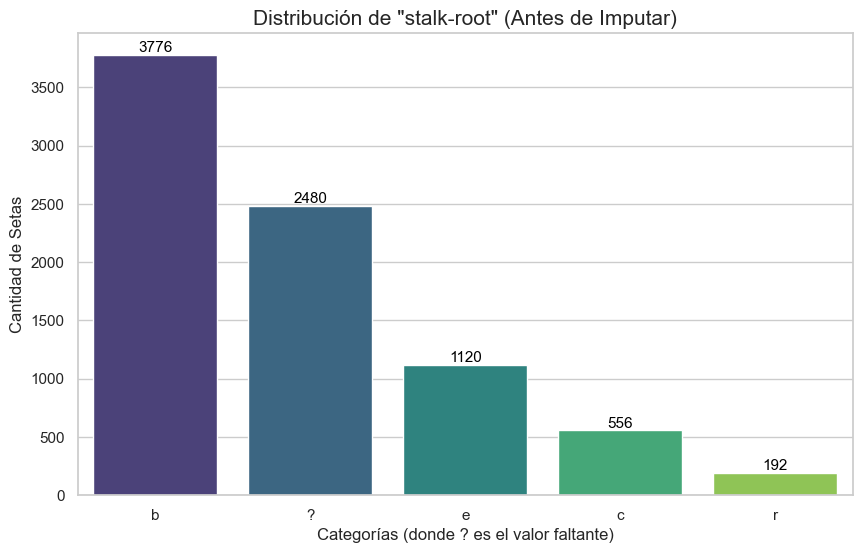

In [11]:
# --- Visualización del problema: la columna stalk-root ---

import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Creamos el gráfico de barras (Countplot) para ver cuántos '?' hay
# Usamos viridis para que se vea profesional
ax = sns.countplot(x='stalk-root', data=df, palette='viridis',
                   order=df['stalk-root'].value_counts().index)

# Títulos y etiquetas claras
plt.title('Distribución de "stalk-root" (Antes de Imputar)', fontsize=15)
plt.xlabel('Categorías (donde ? es el valor faltante)', fontsize=12)
plt.ylabel('Cantidad de Setas', fontsize=12)

# Este código "magia" pone el número exacto sobre cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

## 4. Imputación avanza KNN
Este es el bloque más complejo. Vamos a usar el algoritmo KNN (K-Nearest Neighbors), que rellena los huecos mirando las setas que más se parecen a la que tiene el ?.

In [12]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# 1. Preparación: Reemplazamos '?' por NaN reales (vacíos que el ordenador sí entiende)
df_clean = df.copy()
df_clean['stalk-root'] = df_clean['stalk-root'].replace('?', np.nan)

# 2. Paso Intermedio: Como KNN solo entiende números, codificamos temporalmente las letras
# (Este bloque es un poco técnico, pero básicamente traduce cada letra a un número)
encoders = {}
df_encoded = df_clean.copy()

for col in df_encoded.columns:
    le = LabelEncoder()
    mask = df_encoded[col].notnull() # Solo codificamos donde NO hay nulos
    df_encoded.loc[mask, col] = le.fit_transform(df_encoded.loc[mask, col])
    encoders[col] = le

# 3. La MAGIA: Aplicamos el Imputador KNN
# Mira las 5 setas más parecidas (n_neighbors=5) para decidir qué poner en el hueco
imputer = KNNImputer(n_neighbors=5)
df_imputed_num = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df.columns)

# 4. Decodificación: Volvemos a convertir los números en letras originales
df_final = df_imputed_num.copy()
for col in df_final.columns:
    # Convertimos a entero (porque KNN devuelve decimales) y recuperamos la letra
    df_final[col] = encoders[col].inverse_transform(df_final[col].round().astype(int))

# 5. Verificación: ¿Ha funcionado?
print("Valores en stalk-root tras la magia del KNN:")
print(df_final['stalk-root'].value_counts())

Valores en stalk-root tras la magia del KNN:
stalk-root
b    4845
e    1752
c    1335
r     192
Name: count, dtype: int64


### Visualización Post-Imputación

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11608\1489838950.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='stalk-root', data=df_final, palette='viridis',


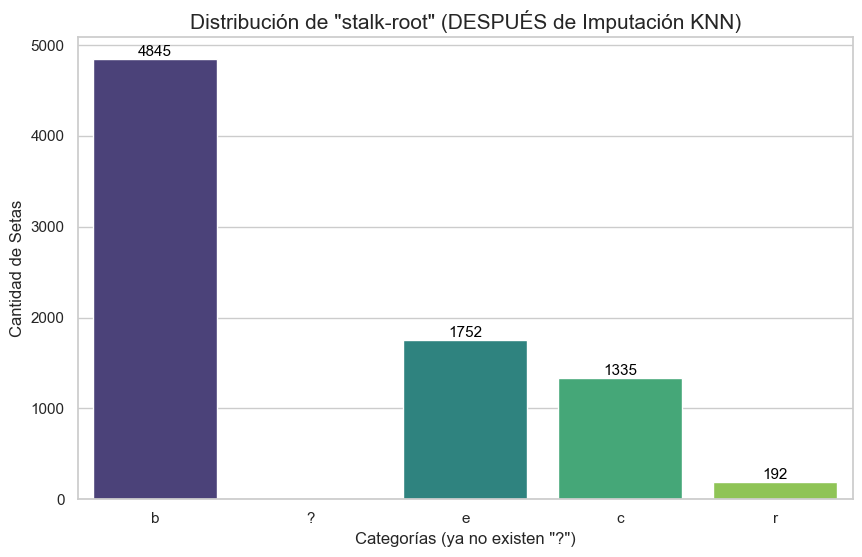

In [14]:
# Visualización del resultado: stalk-root después de la imputación 

# Muy importante: ahora usamos df_final (que es el resultado del KNN)
plt.figure(figsize=(10, 6))

# Usamos el mismo orden de antes para que sea fácil comparar a ojo
ax = sns.countplot(x='stalk-root', data=df_final, palette='viridis', 
                   order=df['stalk-root'].value_counts().index)

plt.title('Distribución de "stalk-root" (DESPUÉS de Imputación KNN)', fontsize=15)
plt.xlabel('Categorías (ya no existen "?")', fontsize=12)
plt.ylabel('Cantidad de Setas', fontsize=12)

# Volvemos a poner los numeritos sobre las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### 4.1. Verificación Visual: Datos Imputados - Categorías Reales
Una vez completada la imputación KNN, generamos la gráfica definitiva de `stalk-root`. En esta visualización **solo aparecerán las categorías reales** de la seta (b, e, c, r). La barra del valor desconocido `?` ha sido eliminada por completo de la estructura, confirmando que nuestro dataset ya es 100% íntegro.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11608\555585281.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


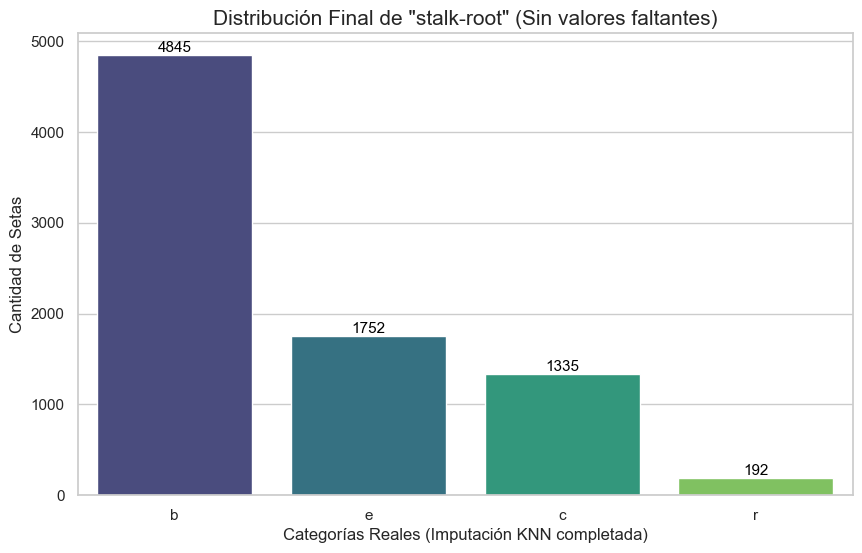

In [17]:
#  Visualización del resultado final EXCLUYENDO la categoría '?' 

# 1. Definimos el tamaño de la gráfica
plt.figure(figsize=(10, 6))

# 2. Creamos el gráfico con df_final
# CAMBIO CLAVE: Usamos df_final['stalk-root'].value_counts().index
# Esto le dice a Seaborn que SOLO pinte las categorías que tienen datos ahora.
ax = sns.countplot(
    x='stalk-root', 
    data=df_final, 
    palette='viridis', 
    order=df_final['stalk-root'].value_counts().index 
)

# 3. Títulos y etiquetas descriptivas
plt.title('Distribución Final de "stalk-root" (Sin valores faltantes)', fontsize=15)
plt.xlabel('Categorías Reales (Imputación KNN completada)', fontsize=12)
plt.ylabel('Cantidad de Setas', fontsize=12)

# 4. Etiquetas de valor sobre las barras
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', 
        va='center', 
        fontsize=11, 
        color='black', 
        xytext=(0, 5),
        textcoords='offset points'
    )

# 5. Mostrar resultado
plt.show()

## 5. Limpieza y Separación y codificaión
Tengo el df_final limpio, vamos a preparar los datos para los modelos.

En esta fase preparamos definitivamente los datos para los algoritmos. Los modelos de Machine Learning no pueden leer texto, así que transformaremos todo a una matriz numérica, asegurándonos de que los datos estén equilibrados.

### 5.1 Limpieza final y separación de variables

In [20]:
# --- Paso 5.1: Limpieza final y separación de variables (CORREGIDO) ---

# 1. Eliminamos 'veil-type' con errores='ignore' para que no falle si ya no existe
df_final.drop(columns=['veil-type'], inplace=True, errors='ignore')

# 2. Separamos la variable objetivo 'y'
y = df_final['class']

# 3. Separamos las características 'X'
X = df_final.drop(['class'], axis=1)

print("✅ Variables X e y separadas.")
print(f"Dimensiones de X (características): {X.shape}")

✅ Variables X e y separadas.
Dimensiones de X (características): (8124, 21)


In [22]:
#prueba de algodon, hacemos un df final con las columnas que tenemos ahora, para ver que veil-type ya no está, y que stalk-root ya no tiene '?'
df_final.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [13]:
# A. Eliminamos veil-type (vimos en el EDA que no aporta nada, siempre es 'p')
df_final.drop(columns=['veil-type'], inplace=True)

# B. Separamos X (preguntas/características) e y (respuesta/clase)
y = df_final['class']
X = df_final.drop(['class'], axis=1)

# C. One-Hot Encoding: Convertimos todas las letras en columnas de 0 y 1
X = pd.get_dummies(X)

print(f"Dataset listo para modelar. Dimensiones de X: {X.shape}")

Dataset listo para modelar. Dimensiones de X: (8124, 115)


### 5.2. Verificación de Balanceo del Target
Antes de codificar, comprobamos si hay un número similar de setas comestibles ('e') y venenosas ('p'). Un dataset desequilibrado (ej. 90% comestibles) podría sesgar el modelo.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11608\3402650271.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette='magma') # Usamos Magma para variar el color


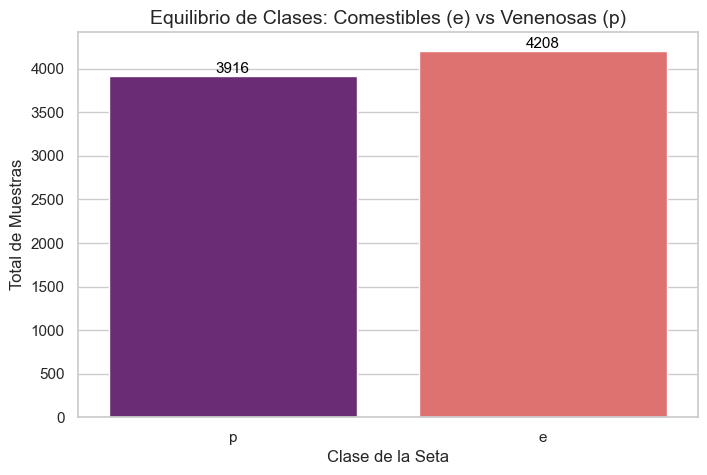

In [23]:
# Visualizamos la distribución de la variable objetivo 'y'
plt.figure(figsize=(8, 5))
ax = sns.countplot(x=y, palette='magma') # Usamos Magma para variar el color

plt.title('Equilibrio de Clases: Comestibles (e) vs Venenosas (p)', fontsize=14)
plt.xlabel('Clase de la Seta', fontsize=12)
plt.ylabel('Total de Muestras', fontsize=12)

# Añadimos etiquetas de valor
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### 5.3 Codificación (Dummies) y Escalado (StandardScaler)

In [26]:

# 1. One-Hot Encoding: Convertimos las letras en columnas de 0 y 1
# Esto crea una matriz mucho más ancha (aprox 115 columnas)
X_dummies = pd.get_dummies(X)

# 2. ESCALADO (Paso Senior): Ponemos todos los datos en la misma escala
# Es obligatorio para que el PCA funcione correctamente
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dummies)

# Convertimos el resultado (que es un array) de nuevo a un DataFrame para verlo mejor
X_final = pd.DataFrame(X_scaled, columns=X_dummies.columns)

print(f"Datos listos. X_final tiene ahora {X_final.shape[1]} columnas numéricas.")
X_final.head(3) # Echamos un vistazo a las primeras filas del resultado

Datos listos. X_final tiene ahora 115 columnas numéricas.


,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,2.347257,-0.994599,-0.51672,-0.795385,-0.599531,-0.337783,-0.193088,-0.404842,4.590870,-0.155582
1,-0.242725,-0.022195,-0.79621,-0.336878,-0.062885,1.105487,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,1.667970,-0.337783,-0.193088,-0.404842,-0.217824,-0.155582
2,4.119885,-0.022195,-0.79621,-0.336878,-0.062885,-0.904579,-0.632238,-0.022195,1.475942,-0.815325,...,-0.426029,-0.994599,-0.51672,-0.795385,-0.599531,-0.337783,5.178988,-0.404842,-0.217824,-0.155582


### 5.4. Verificación del Incremento de Dimensionalidad
Al usar `One-Hot Encoding`, cada categoría de cada columna se ha convertido en una columna independiente. Es importante visualizar cuánto ha crecido nuestro dataset: hemos pasado de variables cualitativas (letras) a una matriz numérica de 115 dimensiones. Esta "explosión" de datos es precisamente la que justifica el uso de **PCA** en el siguiente paso para simplificar la información.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_11608\3344861681.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=nombres_ejes, y=valores_ejes, palette=colores)


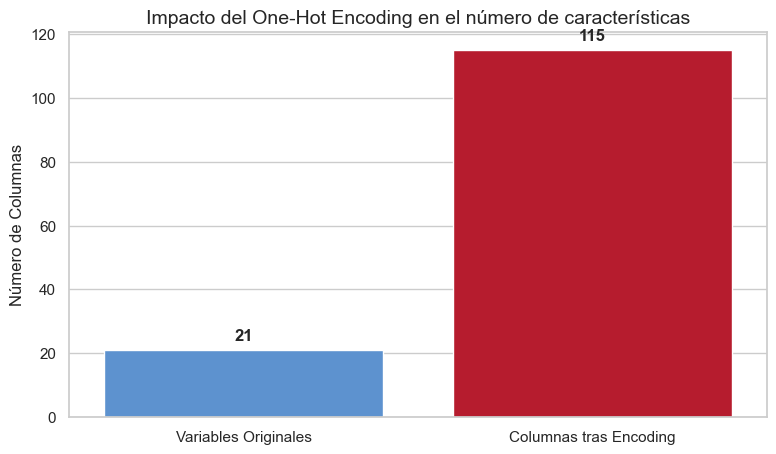

In [27]:
# Visualización del impacto de la codificación One-Hot

# 1. Preparamos los datos para comparar el 'Antes' y el 'Después'
# 'X' era el dataframe con letras, 'X_final' es el dataframe con 0s y 1s
nombres_ejes = ['Variables Originales', 'Columnas tras Encoding']
valores_ejes = [X.shape[1], X_final.shape[1]]

# 2. Configuramos el estilo visual
plt.figure(figsize=(9, 5))
colores = ['#4A90E2', '#D0021B'] # Azul para el origen, Rojo para la explosión

# 3. Creamos un gráfico de barras para comparar las cantidades
sns.barplot(x=nombres_ejes, y=valores_ejes, palette=colores)

# 4. Añadimos etiquetas de contexto
plt.title('Impacto del One-Hot Encoding en el número de características', fontsize=14)
plt.ylabel('Número de Columnas', fontsize=12)

# 5. Añadimos el número exacto sobre cada barra para mayor claridad
for i, v in enumerate(valores_ejes):
    plt.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

¿Qué aprendemos con esta gráfica?
Vemos claramente cómo el dataset se ha vuelto mucho más "ancho". Esto es el "infierno de la dimensionalidad": tenemos demasiadas columnas para procesar eficientemente. ¡Pero dice my friend IA que no me debo preocupar porque el PCA lo arreglará enseguida!

#### Mirad cuántos valores hay en cada feature, ¿Todas las features aportan información? Si alguna no aporta información, eliminadla

In [ ]:
# Dejar por el camino si procede.

#### Separar entre variables predictoras y variables a predecir

In [ ]:
# La variable que trata de predecir este conjunto de datos es 'poisonous'.
y =
X =

SyntaxError: invalid syntax (ipython-input-3365642098.py, line 2)

#### Codificar correctamente las variables categóricas a numéricas

In [ ]:
# One Hot Encoder (una linea).

#### Train test split

In [ ]:
# Os lo dejamos a todos igual
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## PCA

Es un conjunto de datos del que aún no hemos visto nada (no tenemos graficas) así que vamos a hacer algunas. Tenemos el problema de que son muchas variables, **PCA al rescate**: le pedimos que nos de dos dimensiones y las pintamos, sabemos que serán **aquellas que retengan más información**.

In [ ]:
pca =       # metodo de sklearn
pca.fit(X_train)

# Representar en un scatterplot y poner en color las etiquetas de entrenamiento

Parece que está bastante separadito, parece que a ojo mucho se puede ver :)

Igualmente, vamos a entrenar un clasificador a ver qué tal lo hace antes de editar más

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Definir el clasificador y el número de estimadores
# 2. Entrenar en train
# 3. Calcular la precisión sobre test

Es un conjunto sencillo y Random Forest es muy bueno en su trabajo, Igualmente, vamos a ver qué tamaño tenemos de dataset:


In [ ]:
X_train.shape

¿Muchas features no? Vamos a reducir las usando PCA.

In [ ]:
n_features = # definir un rango de valores a probar
scores = []

for n in n_features:

    # Hacer PCA sobre X_train
    # 1. Definir PCA
    # 2. Aprender PCA sobre X_train

    # Entrenar Random Forest
    # 1. Definir el RF
    # 2. Entrenar clasificador

    # Guardar el score


sns.lineplot(x=n_features, y=scores)


Vale, estamos viendo que a partir de unas 10 features ya tenemos el score que queríamos y además hemos reducido las variables a un 10% de las que teníamos, incluso menos que las variables originales.

## Clustering

Viendo que el conjunto de datos es sencillito, podemos intentar hacer algo de clustering a ver qué información podemos obtener.

El primer paso va a ser importar la función de Kmeans de sklearn, y a partir de ahi, vamos a buscar el valor óptimo de clusters. Como hemos visto anteriormente, este valor lo obtenemos, por ejemplo, del codo de la gráfica que representa el total de las distancias de los puntos a los centros de los clusters asociados. Os dejo la página de la documentación de sklearn para que lo busquéis:

[K-Means on sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Con esto solo hay que ahora generar los modelos de kmeans, evaluar y pintar la gráfica para los valores de ``k`` que establezcais.




In [ ]:
from sklearn.cluster import KMeans

scores = []
k_values = # definir un rango
for a in k_values:

    # Definir Kmeans y ajustar
    # Guardar la predicción

sns.lineplot(x=k_values, y=scores)

Con el valor que hayáis obtenido de la gráfica, podéis obtener una buena aproximación de Kmeans y con ello podemos pasar a explorar cómo de bien han separado la información los distintos clusters. Para ello, se va a hacer un ``catplot``, seaborn os lo hará solito. Con esto lo que se pretende ver es la distribución de la varaible a predecir en función del cluster que haya determinado Kmeans.

In [ ]:
# Aprender Kmeans con el valor de K obtenido.

kmeans = # Definir y entrenar Kmeans.

# Preparar el catplot.


# Pintar.
ax = sns.catplot(col=, x=, data=, kind='count',col_wrap=4)

Vamos a ver qué tal queda esto pintado. Para ello, repetimos el scatterplot de antes pero usando como color el cluster asignado por kmeans.

In [ ]:
# Entrenar PCA para representar.

# Usar un color por cada cluster.


¿Es bastante parecido no? No es tan bueno como el Random Forest, pero ha conseguido identificar bastante bien los distintos puntos del dataset sin utilizar las etiquetas. De hecho, el diagrama de factor que hemos visto antes muestra que solo un par de clusters son imprecisos. Si no hubieramos tenido etiquetas esta aproximacion nos hubiera ayudado mucho a clasificar los distintos tipos de hongos.